# OSM Computation: Week 6
## Rebekah Dix

In [1]:
import numpy as np
import sympy as sy
from matplotlib import pyplot as plt
from scipy import linalg as la
from scipy import stats as sts
from scipy import integrate
from scipy import optimize as opt
import autograd.numpy as anp
from autograd.numpy.linalg import solve, norm
from autograd import grad, jacobian
from scipy import sparse

# Differentiation

## Problem 1

In [2]:
def problem_1():
    
    x = sy.symbols('x')
    f = (sy.sin(x) + 1) ** (sy.sin(sy.cos(x)))
    df = sy.diff(f, x)
    lam_df = sy.utilities.lambdify(x, df)
    lam_f = sy.utilities.lambdify(x, f)
    
    return lam_f, lam_df

In [3]:
f, df = problem_1()

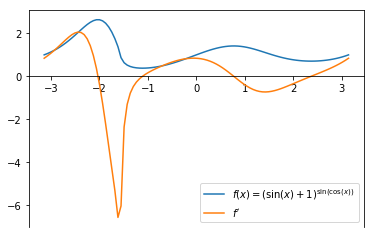

In [4]:
ax = plt.gca()
ax.spines["bottom"].set_position("zero")
domain = np.linspace(-np.pi, np.pi, 100)
ax.plot(domain, f(domain), label=r'$f(x) = (\sin(x) + 1)^{\sin(\cos(x))}$')
ax.plot(domain, df(domain), label=r'$f^{\prime}$')
plt.legend()
plt.show()

## Problem 2

In [5]:
def forward_o1(f, x, h): 
    num = f(x+h) - f(x)
    den = h
    return num / den

def forward_o2(f, x, h):
    num = -3 * f(x) + 4 * f(x + h) - f(x + 2 * h)
    den = 2 * h
    return num / den

def backward_o1(f, x, h):
    num = f(x) - f(x-h) 
    den = h
    return num / den

def backward_o2(f, x, h):
    num = 3 * f(x) - 4 * f(x - h) + f(x - 2 * h)
    den = 2 * h
    return num / den

def centered_o2(f, x, h):
    num = f(x + h) - f(x - h)
    den = 2 * h
    return num / den

def centered_o4(f, x, h):
    num = f(x - 2 * h) - 8 * f(x - h) + 8 * f(x + h) - f(x + 2 * h)
    den = 12 * h
    return num / den

In [6]:
def test_func(x):
    return (np.sin(x) + 1) ** (np.sin(np.cos(x)))

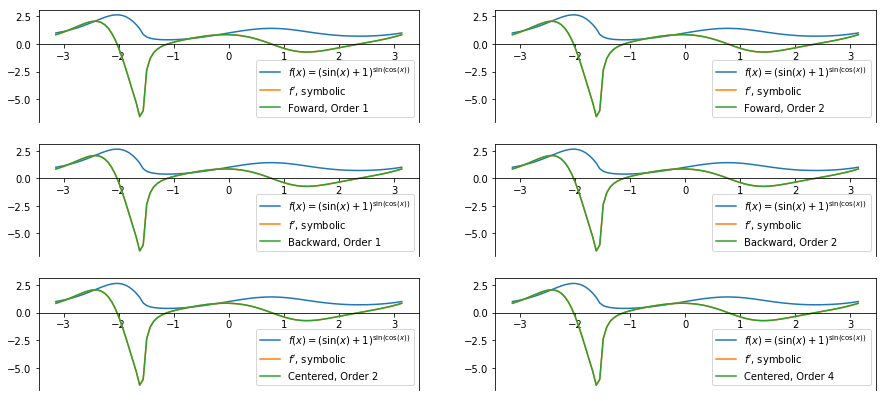

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(15,7))
h = 1e-5

def make_plot(ax, f, symdf, df, domain, h, label):
    ax.spines["bottom"].set_position("zero")
    domain = np.linspace(-np.pi, np.pi, 100)
    ax.plot(domain, f(domain), label=r'$f(x) = (\sin(x) + 1)^{\sin(\cos(x))}$')
    ax.plot(domain, symdf(domain), label=r'$f^{\prime}$, symbolic')
    ax.plot(domain, df(test_func, domain, h), label=label)
    ax.legend()

make_plot(ax[0,0], f, df, forward_o1, domain, h, 'Foward, Order 1')  
make_plot(ax[0,1], f, df, forward_o2, domain, h, 'Foward, Order 2')   
make_plot(ax[1,0], f, df, backward_o1, domain, h, 'Backward, Order 1')   
make_plot(ax[1,1], f, df, backward_o2, domain, h, 'Backward, Order 2')   
make_plot(ax[2,0], f, df, centered_o2, domain, h, 'Centered, Order 2')   
make_plot(ax[2,1], f, df, centered_o4, domain, h, 'Centered, Order 4')   
plt.show()

These approximations seem to match very well. 

Let's check the L-infinity norms for the difference of the analytical/symbolic derivative and the approximate derivatives:

In [8]:
np.linalg.norm(df(domain) - forward_o1(test_func, domain, h), np.inf)

0.0007585211756913068

In [9]:
np.linalg.norm(df(domain) - forward_o2(test_func, domain, h), np.inf)

3.1597151473050644e-07

As expected, the order 2 approximation error is less than the order 1 approximiation error.

In [10]:
np.linalg.norm(df(domain) - backward_o1(test_func, domain, h), np.inf)

0.0007588362973107721

In [11]:
np.linalg.norm(df(domain) - backward_o2(test_func, domain, h), np.inf)

3.1595486138513706e-07

The forward/backward errors are very similar.

In [12]:
np.linalg.norm(df(domain) - centered_o2(test_func, domain, h), np.inf)

1.5756080973261533e-07

In [13]:
np.linalg.norm(df(domain) - centered_o4(test_func, domain, h), np.inf)

2.786721964298522e-10

As expected, the errors for the centered approximation are much lower.

## Problem 3

In [14]:
h = np.logspace(-8, 1, num=10)
fo1 = np.zeros(len(h), dtype=np.float64)
fo2 = np.zeros(len(h), dtype=np.float64)
bo1 = np.zeros(len(h), dtype=np.float64)
bo2 = np.zeros(len(h), dtype=np.float64)
co2 = np.zeros(len(h), dtype=np.float64)
co4 = np.zeros(len(h), dtype=np.float64)

In [15]:
f, df = problem_1()
domain = 1

In [16]:
for index, hlevel in enumerate(h):
    fo1[index] = np.abs(df(domain) - forward_o1(test_func, domain, hlevel))
    fo2[index] = np.abs(df(domain) - forward_o2(test_func, domain, hlevel))
    bo1[index] = np.abs(df(domain) - backward_o1(test_func, domain, hlevel))
    bo2[index] = np.abs(df(domain) - backward_o2(test_func, domain, hlevel))
    co2[index] = np.abs(df(domain) - centered_o2(test_func, domain, hlevel))
    co4[index] = np.abs(df(domain) - centered_o4(test_func, domain, hlevel))

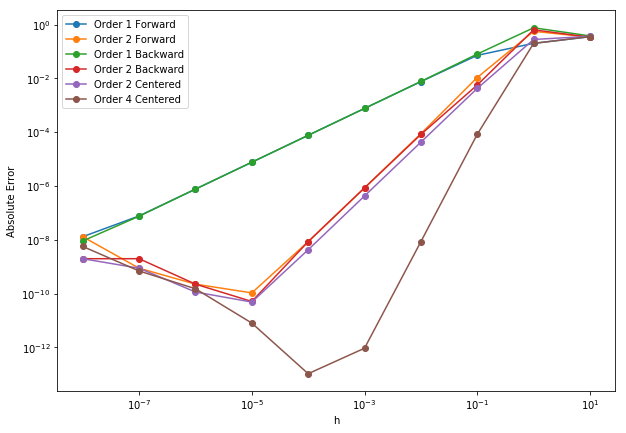

In [17]:
fig = plt.figure(figsize=(10,7))
plt.loglog()
plt.plot(h, fo1, '-o', label='Order 1 Forward')
plt.plot(h, fo2, '-o', label='Order 2 Forward')
plt.plot(h, bo1, '-o', label='Order 1 Backward')
plt.plot(h, bo2, '-o', label='Order 2 Backward')
plt.plot(h, co2, '-o', label='Order 2 Centered')
plt.plot(h, co4, '-o', label='Order 4 Centered')
plt.legend()
plt.xlabel('h')
plt.ylabel('Absolute Error')
plt.show()

## Problem 4

In [18]:
data = np.load('plane.npy')

In [19]:
data

array([[ 7.  , 56.25, 67.54],
       [ 8.  , 55.53, 66.57],
       [ 9.  , 54.8 , 65.59],
       [10.  , 54.06, 64.59],
       [11.  , 53.34, 63.62],
       [12.  , 52.69, 62.74],
       [13.  , 51.94, 61.72],
       [14.  , 51.28, 60.82]])

In [20]:
alpha_rad = np.radians(data[:,1])
beta_rad = np.radians(data[:,2])
a = 500

In [21]:
xpos = a * np.tan(beta_rad) / (np.tan(beta_rad) - np.tan(alpha_rad))
ypos  = a * np.tan(beta_rad) * np.tan(alpha_rad) / (np.tan(beta_rad)- np.tan(alpha_rad))

In [22]:
t = np.arange(8, 14)

In [23]:
xprime = np.zeros(8, dtype=np.float64)
yprime = np.zeros(8, dtype=np.float64)
h = 1e-4

for ii in range(len(xprime)):
    if ii == 0:
        xprime[ii] = xpos[ii+1] - xpos[ii]
        yprime[ii] = ypos[ii+1] - ypos[ii]
    elif ii == 7:
        xprime[ii] = xpos[ii] - xpos[ii-1] 
        yprime[ii] = ypos[ii] - ypos[ii-1] 
    else:
        xprime[ii] = .5 * (xpos[ii+1] - xpos[ii-1])
        yprime[ii] = .5 * (ypos[ii+1] - ypos[ii-1])

In [24]:
speed = np.sqrt(xprime ** 2 + yprime ** 2)

In [25]:
speed

array([46.42420062, 47.00103938, 48.99880514, 50.09944163, 48.29035084,
       51.56455905, 53.92303355, 51.51480057])

## Problem 5

In [26]:
def approx_jacob(f, x, h):
    n = np.shape(x)[0]
    m = np.shape(f(x))[0]
    
    jacobian = np.zeros((m,n))
    for ii in range(n):
        eii = np.eye(n)[:,ii]
        jacobian[:, ii] = (f(x + h * eii) - f(x - h * eii)) / (2 * h)
    return jacobian

In [27]:
f = lambda x: np.array([x[0] ** 2, x[0] ** 3 - x[1]])

In [28]:
approx_jacob(f, np.array([0, 0]), 1e-4)

array([[ 0.e+00,  0.e+00],
       [ 1.e-08, -1.e+00]])

In [29]:
x, y = sy.symbols('x, y')
f1 = x ** 2
f2 = x ** 3 - y
F = sy.Matrix([f1,f2])  
F.jacobian([x,y])

Matrix([
[   2*x,  0],
[3*x**2, -1]])

In [30]:
F.jacobian([x,y]).subs([(x,0), (y,0)])

Matrix([
[0,  0],
[0, -1]])

This result matches!

## Problem 6 

In [31]:
from autograd import numpy as anp
from autograd import grad
from autograd import elementwise_grad

In [32]:
def T(x, n):
    
    if n == 0:
        return anp.ones_like(x)
    elif n == 1:
        return x
        
    return 2 * x * T(x, n - 1) - T(x, n - 2)

/Users/rebekahdix/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


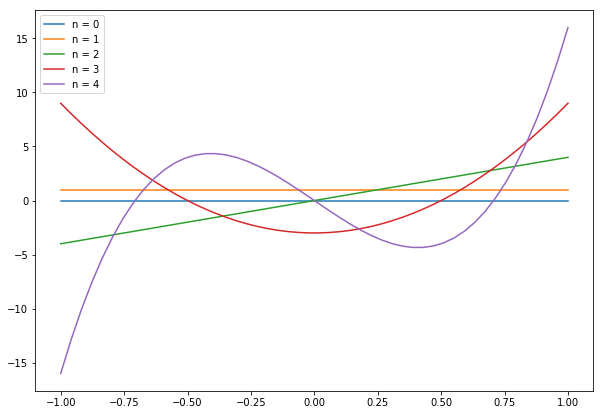

In [33]:
dT = elementwise_grad(T)
x_grid = anp.linspace(-1, 1)
plt.figure(figsize=(10, 7))
for nn in range(5):
    plt.plot(x_grid, dT(x_grid, nn), label=f'n = {nn}')
plt.legend()
plt.show()

## Problem 7

In [34]:
import time
from autograd import grad

def exp(N):
    
    func = lambda x: (anp.sin(x) + 1) ** (anp.sin(anp.cos(x)))
    time_sym = np.zeros(N, dtype=np.float64)
    time_autograd = np.zeros(N, dtype=np.float64)
    time_centered = np.zeros(N, dtype=np.float64)
    
    err_centered = np.zeros(N, dtype=np.float64)
    err_autograd = np.zeros(N, dtype=np.float64)

    
    for ii in range(N):
        # Choose a random value x0
        x0 = np.random.rand()
        
        # Use function from Problem 1 to calculate the “exact” value of f prime
        time_start_exact = time.time()
        f, df = problem_1()
        time_sym[ii] =  time.time() - time_start_exact
        
        # Time approximation of fprime using fourth-rder centered difference quotient
        time_start_centered = time.time()
        err_centered[ii] = np.abs(centered_o4(func, x0, 1e-4) - df(x0))
        time_centered[ii] =  time.time() - time_start_centered
        
        #Time approximation of fprime using Autograd
        dfgrad = grad(func)
        time_start_autograd = time.time()
        err_autograd[ii] = np.abs(dfgrad(x0) - df(x0))
        time_autograd[ii] = time.time() - time_start_autograd
            
    # Create plot of time vs error
    fig = plt.figure(figsize=(10, 7))
    # Plot errors
    plt.scatter(time_sym, 1e-18 * np.ones(N), alpha=0.5, label='Exact, SymPy', s=30)
    plt.scatter(time_centered, err_centered, alpha=0.5, label='Centered Difference', s=30)
    plt.scatter(time_autograd, err_autograd, alpha=0.5, label='Autograd', s=30)
    # Settings
    plt.loglog()
    plt.xlim(1e-5, 1e-1)
    plt.ylim(1e-19, 1e-11)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Absolute Error')
    plt.legend()
    plt.show()

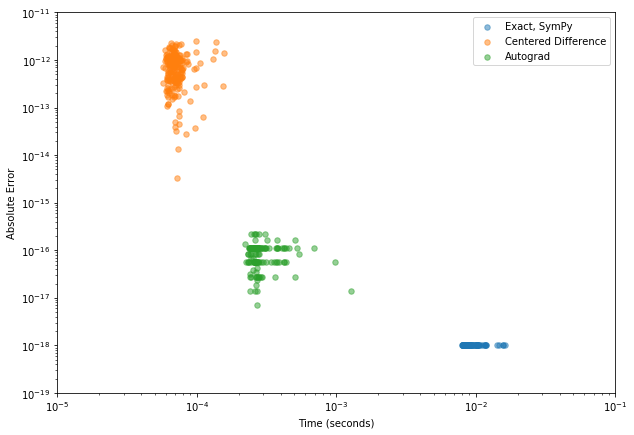

In [35]:
exp(200)

# Numerical Integration

## Exercise 14.1

In [36]:
def int_approx(g, a, b, N, method):
    
    int_sum = 0
    
    if method == 'midpoint':
        x = np.zeros(N, dtype=np.float64)
        for ii in range(N):
            x[ii] = a + (2 * ii + 1) * (b - a) / (2 * N)
            int_sum += g(x[ii])
            
        int_sum = (b - a) / N * int_sum
        
    elif method == 'trapezoid':
        x = np.zeros(N+1, dtype=np.float64)
        for ii in range(N+1):
            x[ii] = a + ii * (b - a) / (N)
            if ii == 0:
                int_sum += g(x[ii])
            elif ii == N:
                int_sum += g(x[ii])
            elif ii != N and ii != 0:
                int_sum += 2 * g(x[ii])
                
        int_sum = ((b - a) / (2 * N)) * int_sum
        
    elif method == 'Simpsons':
        x = np.zeros(2*N + 1, dtype=np.float64)
        for ii in range(2*N + 1):
            x[ii] = a + (ii * (b - a) / (2 * N))
            if ii == 0:
                int_sum += g(x[ii])
            elif ii == 2 * N:
                int_sum += g(x[ii])
            elif ii % 2 == 1:
                int_sum += 4 * g(x[ii])
            elif ii % 2 == 0:
                int_sum += 2 * g(x[ii])  
                
        int_sum *= (b - a) / (3 * (2*N + 1))
        
    else:
        raise ValueError('Unrecognized method.')    
        
    return int_sum

In [37]:
def g(x):
    return .1 * x ** 4 - 1.5 * x ** 3 + .53 * x ** 2 + 2 * x + 1

In [38]:
midpoint = int_approx(g, -10, 10, 10000, 'midpoint')
midpoint

4373.333196466632

In [39]:
trap = int_approx(g, -10, 10, 10000, 'trapezoid')
trap

4373.333607066684

In [40]:
simp = int_approx(g, -10, 10, 10000, 'Simpsons')
simp

4373.114677599493

These three approximations are very close to the true analytical value. I initial thought that Simpson's rule would perform better, but it is further away from the true analytical value than both the midpoint and the trapezoid rule. 

## Exercise 14.2

In [41]:
def nc_approx_normal(mu, sd, N, k):
    """
    This function makes a Newton-Cotes discrete approximation of the distribution 
    of the normally distributed variable Z ∼ N(µ, σ).
    
    Inputs:
        mu (scalar) : the mean
        sd (scalar) : the standard deviation
        N (scalar) : the number of equally spaced nodes used to 
                    approximate the distribution
        k (scalar) : the number of standard deviations away from mu
                     to make the furthest nodes on either side of mu
    
    Returns:
        w (vector) : vector of weights
        Z (vector) : vector of nodes
    """
    Z = np.linspace(mu - k*sd, mu + k*sd, N)
    w = np.zeros(N, dtype=np.float64)
    for ii in range(1, N+1):
        if ii == 1:
            w[ii-1] = sts.norm.cdf((Z[ii-1] + Z[ii]) / 2, loc=mu, scale=sd)
        elif ii == N:
            w[ii-1] = 1 - sts.norm.cdf((Z[N-2] + Z[N-1]) / 2, loc=mu, scale=sd)
        else:
            w[ii-1] = sts.norm.pdf(Z[ii-1], loc=mu, scale=sd) \
            * (Z[N-1] - Z[0])/N
    
    return w, Z
                     
            

Weights and nodes for $N = 11$:

In [42]:
w, Z = nc_approx_normal(0, 1, 11, 4)

In [43]:
w

array([1.59108590e-04, 1.73388233e-03, 1.62869311e-02, 8.06696979e-02,
       2.10684766e-01, 2.90139840e-01, 2.10684766e-01, 8.06696979e-02,
       1.62869311e-02, 1.73388233e-03, 1.59108590e-04])

In [44]:
Z

array([-4. , -3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2,  4. ])

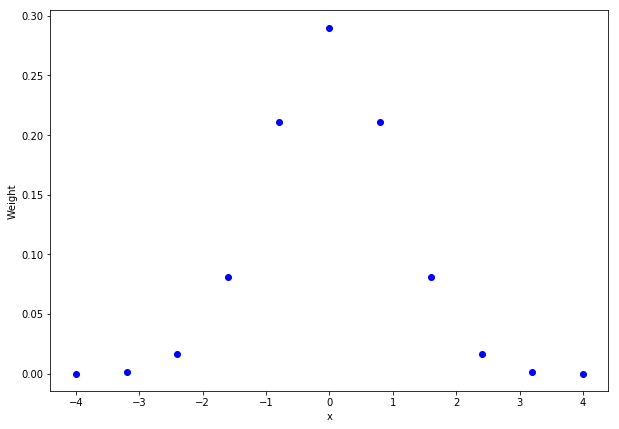

In [45]:
fig = plt.figure(figsize=(10,7))
plt.plot(Z, w, 'bo')
plt.xlabel('x')
plt.ylabel('Weight')
plt.show()

## Exercise 14.3

In [46]:
def approx_log_norm(mu, sd, N, k):
    """
    This function makes a Newton-Cotes discrete approximation of the distribution 
    of the lognormally distributed variable A ∼ LN(µ, σ).
    
    Inputs:
        mu (scalar) : the mean
        sd (scalar) : the standard deviation
        N (scalar) : the number of equally spaced nodes used to 
                    approximate the distribution
        k (scalar) : the number of standard deviations away from mu
                     to make the furthest nodes on either side of mu
    
    Returns:
        w (vector) : vector of weights
        A (vector) : vector of nodes
    """
    
    w, Z = nc_approx_normal(mu, sd, N, k)
    A = np.exp(Z)
    
    return w, A
    

In [47]:
w, A = approx_log_norm(0, 1, 11, 4)

In [48]:
w

array([1.59108590e-04, 1.73388233e-03, 1.62869311e-02, 8.06696979e-02,
       2.10684766e-01, 2.90139840e-01, 2.10684766e-01, 8.06696979e-02,
       1.62869311e-02, 1.73388233e-03, 1.59108590e-04])

In [49]:
A

array([1.83156389e-02, 4.07622040e-02, 9.07179533e-02, 2.01896518e-01,
       4.49328964e-01, 1.00000000e+00, 2.22554093e+00, 4.95303242e+00,
       1.10231764e+01, 2.45325302e+01, 5.45981500e+01])

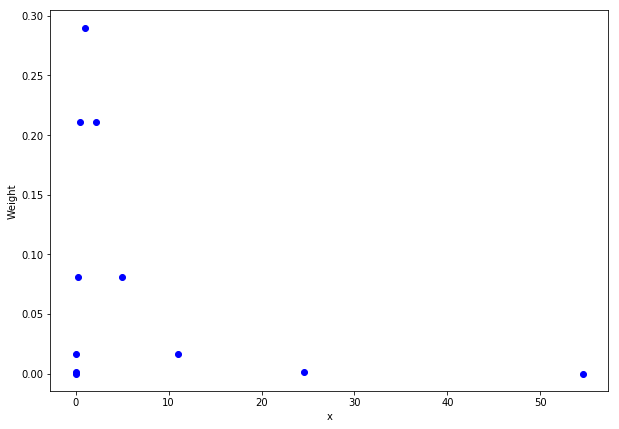

In [50]:
fig = plt.figure(figsize=(10,7))
plt.plot(A, w, 'bo')
plt.xlabel('x')
plt.ylabel('Weight')
plt.show()

## Exercise 14.4

In [51]:
mu = 10.5
sd = .8
N = 100
k = 4

In [52]:
w, A = approx_log_norm(mu, sd, N, k)

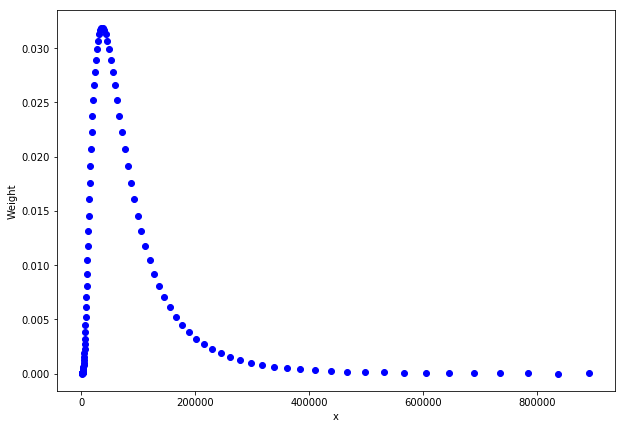

In [53]:
fig = plt.figure(figsize=(10,7))
plt.plot(A, w, 'bo')
plt.xlabel('x')
plt.ylabel('Weight')
plt.show()

In [54]:
aveinc = np.average(A, weights=w)
aveinc

50005.43188241741

Exact expected value:

In [55]:
exact = np.exp(mu + (sd**2)/2)
exact

50011.087008521754

My approximation is fairly close to the exact expected value.

## Exercise 14.5

We use the class of polynomials $h_i(x) = x^i$ and $N=3$. We need to solve a system of 6 equations to determine $(\omega_1, \omega_2, \omega_3, x_1, x_2, x_3)$:
\begin{align*}
    a - b = \int_a^b dx &= \omega_1 + \omega_2 + \omega_3\\
    \frac{a^2 - b^2}{2} = \int_a^b x dx &= \omega_1 x_1 + \omega_2 x_2 + \omega_3 x_3\\
    \frac{a^3 - b^3}{3} = \int_a^b x^2 dx &= \omega_1 x_1^2 + \omega_2 x_2^2 + \omega_3 x_3^2\\
    \frac{a^4 - b^4}{4} = \int_a^b x^3 dx &= \omega_1 x_1^3 + \omega_2 x_2^3 + \omega_3 x_3^3\\
    \frac{a^5 - b^5}{5} = \int_a^b x^4 dx &= \omega_1 x_1^4 + \omega_2 x_2^4 + \omega_3 x_3^4\\
    \frac{a^6 - b^6}{6} = \int_a^b x^5 dx &= \omega_1 x_1^5 + \omega_2 x_2^5 + \omega_3 x_3^5\\
\end{align*}

In [56]:
def system_errors(x):
    w1, w2, w3, x1, x2, x3 = x
    rhs = np.zeros(6, dtype=np.float64)
    for ii in range(6):
        rhs[ii] = (1 ** (ii+1) - (-1) ** (ii+1)) / (ii + 1)
    err = np.zeros(6, dtype=np.float64)
    for ii in range(6):
        err[ii] = np.abs(rhs[ii] - w1 * (x1 ** ii) - w2 * (x2 ** ii) - w3 * (x3 ** ii))
    return err

In [57]:
guess = np.array([1, 1, 1, -.5, 0, .5])
sol = opt.fsolve(system_errors, guess)
sol

array([ 5.55555556e-01,  8.88888889e-01,  5.55555555e-01, -7.74596669e-01,
        6.30422898e-10,  7.74596669e-01])

In [58]:
def g(x):
    return .1 * x ** 4 - 1.5 * x ** 3 + .53 * x ** 2 + 2 * x + 1

In [59]:
np.sum(sol[:3] * g(sol[3:]))

2.3933333333331652

I reduced the range of the integral to be from -1 to 1. With this smaller range, the value of the integral is very close to the analytical value. However, as I increase the bounds, the solution to the system of equations that determines the weights is very unstable and I'm unable to accurately approximate the integral.

## Exercise 14.6

In [60]:
val, error = integrate.quad(g, -10, 10)

In [61]:
val

4373.333333333334

In [62]:
error

8.109531705284936e-11

The approximated integral from the scipy.integrate.quad command is very close to the exact value of the function.

## Exercise 14.7

In [63]:
def mc(g, x, omega, N):
    """
    This function returns the Monte Carlo approximation of the integral
    of g over omega.
    
    Inputs:
        g (function) : anonymous function to be integrated
        omega (rectangle) : domain of g
        N (scalar) : number of random draws
        
    """
    n = len(x)
    vol = np.prod(omega[:,1] - omega[:,0])
    integral = 0
    for ii in range(N):
        draw = np.random.rand(n) * (omega[:, 1] - omega[:,0]) + omega[:,0]
        integral += g(draw.T)
    integral = vol * (1/N) * integral
    
    return integral

In [64]:
def g(x):
    if x[0] ** 2 + x[1] ** 2 <= 1:
        val = 1
    else:
        val = 0
    return val

omega = np.array([[-1, 1], [-1, 1]])

In [65]:
mc(g, np.array([0,0]), omega, 10000)

3.132

In [66]:
mc(g, np.array([0,0]), omega, 1000000)

3.13862

My approximation does not seem to match $\pi$ to many decimal places, even with a large number of draws.

## Exercise 14.8

In [67]:
def n_prime_numbers(n):
    """
    This function generates the first n prime numbers.
    """
    prime_list = [2]
    num = 3
    while len(prime_list) < n:
        for p in prime_list:
            if num % p == 0:
                break
        else:
            prime_list.append(num)
        num += 2
    return prime_list

In [68]:
def equi_seq(n, d, sequence):
    """
    This function returns the n-th element of a d-dimensional
    equidistributed sequence. It supports the weyl, haber,
    niederreiter, and backer sequences.
    
    Inputs:
        n (scalar)       : element in sequence
        d (scalar)       : dimension of sequence
        squence (string) : name of sequence to draw from
                           Types:
                           'weyl' : wey
                           'hab' : haber
                           'nie' : niedeterreiter
                           'bac' : backer
                     
    Returns:
        xn (vector) : nth element of requested sequence
    """
    
    if sequence == 'weyl':
        primes = n_prime_numbers(d)
        x = n * np.power(primes, .5)
        xn = x - np.floor(x)
    elif sequence == 'hab':
        primes = n_prime_numbers(d)
        x = (n * (n + 1.0)) / 2 * np.power(primes, .5)
        xn = x - np.floor(x)
    elif sequence == 'nie':
        ar = np.arange(1, d + 1)
        x = n * (2 ** (ar / (d + 1)))
        x_floor = np.floor(x)
        xn = x - x_floor
    elif sequence == 'bac':
        primes = n_prime_numbers(d)
        x = n * np.exp(primes)
        xn = x - np.floor(x)
    else:
        raise ValueError('Sequence not supported.')
        
    return xn
    

In [69]:
equi_seq(10, 2, 'weyl')

array([0.14213562, 0.32050808])

In [70]:
equi_seq(10, 2, 'hab')

array([0.78174593, 0.26279442])

In [71]:
equi_seq(10, 2, 'nie')

array([0.5992105 , 0.87401052])

In [72]:
equi_seq(5, 2, 'bac')

array([0.94528049, 0.42768462])

In [73]:
N = 10000
weyl_seq = np.zeros((N, 2), dtype=np.float64)
haber_seq = np.zeros((N, 2), dtype=np.float64)
nie_seq = np.zeros((N, 2), dtype=np.float64)
bac_seq = np.zeros((N, 2), dtype=np.float64)
for ii in range(1, N+1):
    weyl_seq[ii-1, :] = equi_seq(ii, 2, 'weyl')
    haber_seq[ii-1, :] = equi_seq(ii, 2, 'hab')
    nie_seq[ii-1, :] = equi_seq(ii, 2, 'nie')
    bac_seq[ii-1, :] = equi_seq(ii, 2, 'bac')

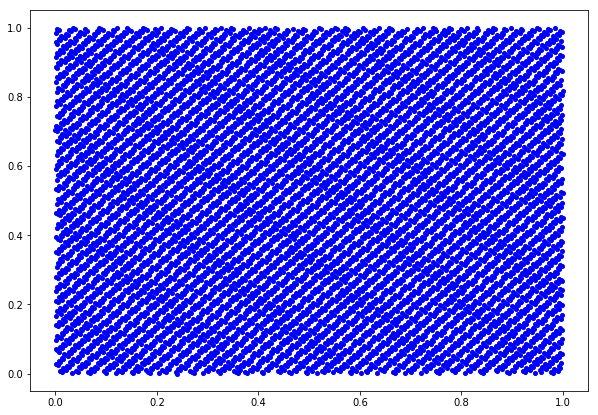

In [74]:
fig = plt.figure(figsize=(10,7))
plt.plot(weyl_seq[:,0], weyl_seq[:,1], 'bo', ms=4)
plt.show()

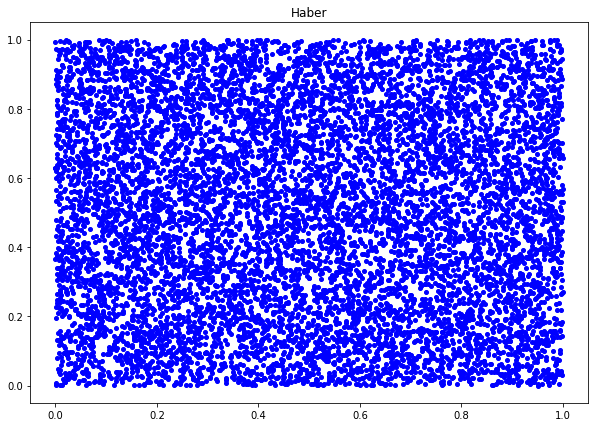

In [75]:
fig = plt.figure(figsize=(10,7))
plt.plot(haber_seq[:,0], haber_seq[:,1], 'bo', ms=4)
plt.title('Haber')
plt.show()

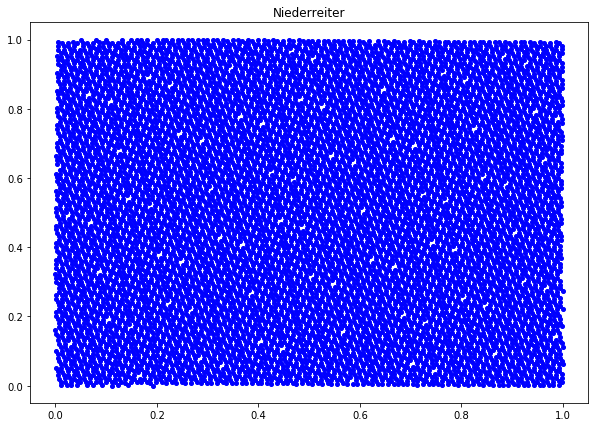

In [76]:
fig = plt.figure(figsize=(10,7))
plt.plot(nie_seq[:,0], nie_seq[:,1], 'bo', ms=4)
plt.title('Niederreiter')
plt.show()

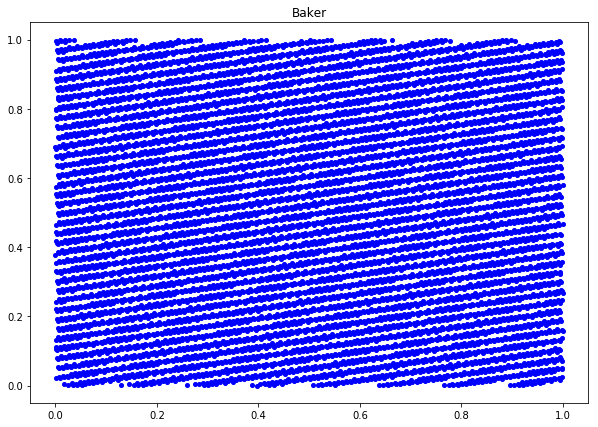

In [77]:
fig = plt.figure(figsize=(10,7))
plt.plot(nie_seq[:,0], bac_seq[:,1], 'bo', ms=4)
plt.title('Baker')
plt.show()

## Exercise 14.9

In [78]:
def approx_pi_quas(N, sequence):
    """
    This function approximates pi using quasi-Monte Carlo integration.
    
    Inputs:
        N (scalar) : number of draws
        sequence (string) : type of sequence to use
    """
    
    pi = 0
    count = 0
    seq = np.zeros((N, 2), dtype=np.float64)
    for ii in range(1, N+1):
        seq[ii-1, :] = equi_seq(ii, 2, sequence)
    
    for ii in range(N):
        if seq[ii,0] ** 2 + seq[ii,1] ** 2 <= 1:
            count += 1
    pi = 4.0 * count / N
    
    return pi

In [79]:
approx_pi_quas(1000000, 'weyl')

3.14148

In [80]:
approx_pi_quas(1000000, 'hab')

3.143308

In [81]:
approx_pi_quas(1000000, 'bac')

3.141564

In [82]:
approx_pi_quas(1000000, 'nie')

3.141464

The rates of convergence for quasi-Monte Carlo integration seem better than regular Monte Carlo integration. The Baker sequence appears to perform particulary well.

# The Simplex Method

## Problems 1 - 6

In [83]:
class LinearProgram:
    """
    
    Attributes:
        L (list): Stores and tracks all of the basic and non-basic variables.
                  The first m variables are basic variables, and the last n
                  variables are non-basic variables.
    
    """
    def __init__(self, c, A, b):
        # For the origin to be feasible at the origin, all entries of
        # b must be (weakly) positive
        if (b >= 0).all():
            pass
        else: 
            raise ValueError('Problem not feasible at the origin.')
        m, n = np.shape(A)
        self.m = m
        self.n = n
        self.c = c
        self.A = A
        self.b = b
        self.L = np.concatenate([np.arange(self.n, self.m + self.n, 1),   
                                 np.arange(0, self.n, 1)])  
        self.T = self.init_tableau()
        
    def init_tableau(self):
        Abar = np.hstack((self.A, np.eye(self.m)))
        cbar = np.hstack((self.c, np.zeros(self.m)))
        row1 = np.hstack((0, -cbar.T, 1))
        row2 = np.hstack((self.b.reshape(self.m,1), Abar, np.zeros((self.m,1))))
        T = np.vstack((row1, row2)) 
        return T
    
    def find_pivot(self):
        """
        This function uses Bland's Rule to determine the pivot row
        and pivot column.
        """
        T = self.T.copy()
        ent = np.argmax(T[0,1:] < 0) + 1
        
        if np.all(T[:, ent] <= 0):
            raise ValueError('The problem is unbounded.')
            
        
        negative = T[:, ent] <= 0
        T[negative, ent] = np.nan
        row_ind = np.nanargmin(T[:, 0] / T[:, ent])
        
        return row_ind, ent
    
    def pivot(self):
        
        # Get current attributes
        L, T, m = self.L, self.T, self.m
        row_ind, col_ind = self.find_pivot()
        self.L[row_ind - 1], self.L[col_ind + m - 1] = self.L[col_ind + m - 1], self.L[row_ind - 1]
        
        # Divide the pivot row by the value of the pivot entry
        T[row_ind, :] /= T[row_ind, col_ind]
        
        # Zero out all entries in the pivot column above and below
        # the pivot entry
        for ii in range(T.shape[0]):
            if ii == row_ind:
                pass
            else:
                factor = -T[ii, col_ind]
                T[ii, :] += factor * T[row_ind, :]
        
        # Update attributes
        self.T = T
        self.L = L
        
    def solve(self):
        
        while np.any(self.T[0, :] < 0):
            self.pivot()
        # The maximum value attained by the objective function is found 
        # in the upper leftmost entry of the tableau.          
        optimum = self.T[0, 0]
        # The basic variables, whose indices are located in the ﬁrst 
        # m entries of the index list
        basic = self.L[:self.m]
        # The nonbasic variables, whose indices are located in the last 
        # n entries of the index list, all have the value 0.
        nonbasic = self.L[self.m:]
        dict1 = dict(zip(basic, self.T[1:, 0]))
        dict2 = dict(zip(nonbasic, np.zeros(self.m)))
        return (optimum, dict1, dict2)
        

In [84]:
c = np.array([3, 2])
A = np.array([[1, -1], [3, 1], [4, 3]])
b = np.array([2, 5, 7])

In [85]:
TestProgram = LinearProgram(c, A, b)
sol = TestProgram.solve()
print(sol)

(5.2, {2: 0.5999999999999996, 0: 1.6, 1: 0.19999999999999982}, {3: 0.0, 4: 0.0})


## Problem 7

In [86]:
data = np.load('productMix.npz')
AA = data['A']
p = data['p']
m = data['m']
d = data['d']
A = np.row_stack([AA, np.eye(4)])
b = np.concatenate([m, d])

In [87]:
Program = LinearProgram(p, A, b)
Program.solve()

(7453.596491228071,
 {1: 6.192982456140348,
  3: 1.7894736842105292,
  6: 0.9659649122807016,
  0: 10.0,
  8: 13.807017543859653,
  2: 12.0,
  10: 8.21052631578947},
 {7: 0.0, 4: 0.0, 9: 0.0, 5: 0.0})

# Newton's Method

## Problem 1

In [88]:
def newton(f, xinit, fprime, tol=1e-5, maxiter=15):
    
    xk = xinit
    err = tol + 1
    converged = False
    for ii in range(1, maxiter+1):
        xkp1 = xk - f(xk) / fprime(xk)
        err = np.abs(xkp1 - xk)
        xk = xkp1
        if err < tol:
            converged = True
            break

    return xk, converged, ii

In [89]:
def f1(x):
    return np.exp(x) - 2
def f1prime(x):
    return np.exp(x)
def f2(x):
    return x ** 4 - 3
def f2prime(x):
    return 4 * x ** 3

In [90]:
zero1 = newton(f1, 1, f1prime)
zero1

(0.6931471805600254, True, 4)

In [91]:
zero1_compare = opt.newton(f1, 1, f1prime)
zero1_compare

0.6931471805599453

In [92]:
zero2 = newton(f2, 1, f2prime)
zero2

(1.3160740129543826, True, 5)

In [93]:
zero2_compare = opt.newton(f2, 1, f2prime)
zero2_compare

1.3160740129524924

## Problem 2

In [94]:
def interest(N1, N2, P1, P2):
    cond1 = lambda r: P1 * ((1 + r) ** N1 - 1) - P2 * (1 - (1 + r) ** -N2)
    condprime1 = lambda r: P1 * N1 * (1 + r) ** (N1 - 1) + P2 * N2 * (1 + r) ** (-N2 - 1)
    root = newton(cond1, .1, condprime1)
    return root

In [95]:
interest(30, 20, 2000, 8000)

(0.038786670117328476, True, 15)

## Problem 3

In [96]:
def newton(f, xinit, fprime, alpha, tol=1e-5, maxiter=15):
    
    xk = xinit
    err = tol + 1
    converged = False
    for ii in range(maxiter):
        xkp1 = xk - alpha * f(xk) / fprime(xk)
        err = np.abs(xkp1 - xk)
        xk = xkp1
        if err < tol:
            converged = True
            break

    return xk, converged, ii

In [97]:
f_1 = lambda x: np.sign(x) * np.power(np.abs(x), 1./3)
fprime_1 = lambda x: (1./3) * np.power(np.abs(x), -2./3)

In [98]:
newton(f_1, .01, fprime_1, 1)

(-327.6800000000003, False, 14)

In [99]:
newton(f_1, .01, fprime_1, .4, maxiter=100)

(6.400000000000134e-07, True, 5)

## Problem 4

In [100]:
def newton_opt(f, xinit, fprime, tol=1e-5, maxiter=15):
    
    alpha = np.linspace(.01, 1, 50)
    numIts = np.zeros(len(alpha))
    
    for index, alp in enumerate(alpha):
        xk = xinit
        err = tol + 1
        for ii in range(1, maxiter+1):
            xkp1 = xk - alp * f(xk) / fprime(xk)
            err = np.abs(xkp1 - xk)
            xk = xkp1
            if err < tol:
                break
        numIts[index] = ii

    return numIts

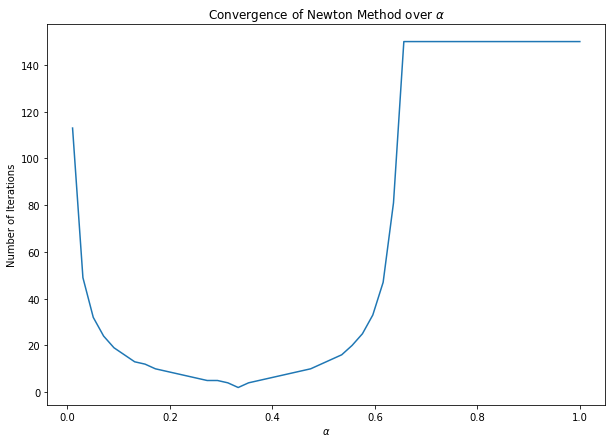

In [101]:
alpha = np.linspace(.01, 1, 50)
numIts = newton_opt(f_1, .01, fprime_1, maxiter=150)
fig = plt.figure(figsize=(10,7))
plt.plot(alpha, numIts)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Number of Iterations')
plt.title(r'Convergence of Newton Method over $\alpha$')
plt.show()

$\alpha$ matters. 

## Problem 5

In [102]:
from scipy.linalg import norm
def newton_n(f, fprime, xinit, alpha, tol=1e-5, maxiter=15):
    """
    Find the zero of an n-dimensional function using Newton's Method.
    """
    
    x = xinit
    diff = tol + 1
    
    if np.isscalar(x):
        return newton(f, xinit, fprime, alpha, tol=1e-5, maxiter=100)
    else:
        current_iter = 0
        while diff > tol and current_iter < maxiter:
            y = np.linalg.solve(fprime(x), f(x))
            x_new = x - alpha * y
            diff = norm(x_new - x, np.inf)
            x = x_new
            current_iter += 1
        return x

Verify that the function still works in the case that n=1:

In [103]:
zero1 = newton_n(f1, f1prime, 1, 1)
zero1

(0.6931471805600254, True, 3)

In [104]:
newton_n(f_1, fprime_1, .01, 1)

(1.2676506002279275e+28, False, 99)

These results match what the one-dimensional functions gave.

## Problem 6

In [105]:
def newton_Rn_adjust(x_0, f, Df, alpha=1, tol=1e-5, maxiter=15):
    it = 0
    while it < maxiter:
        y_0 = solve(Df(x_0), f(x_0))
        x_1 = x_0 - alpha * y_0
        if norm(x_1 - x_0) < tol:
            return x_1
        x_0 = x_1
        it += 1
    return x_1

In [106]:
f = lambda x: anp.array([5*x[0]*x[1] - x[0]*(1 + x[1]), 
                         -x[0]*x[1] + (1 - x[1])*(1 + x[1])])
Df = jacobian(f)

def find_init(f, Df, niter=100):
    # Create search domain
    x_domain = np.linspace(-0.25, 0, 100)
    y_domain = np.linspace(0, 0.25, 100)
    X, Y = np.meshgrid(x_domain, y_domain)
    xy_domain = zip(X.ravel(), Y.ravel())
    
    # See where each point in the domain converges
    for coord in xy_domain:
        try:
            min1 = newton_Rn_adjust(anp.array(coord), f, Df, alpha=1, maxiter=niter)
            min2 = newton_Rn_adjust(anp.array(coord), f, Df, alpha=0.55, maxiter=niter)
            if (np.allclose(min1, anp.array((0, 1))) or np.allclose(min1, anp.array((0, -1)))) and np.allclose(min2, anp.array((3.75, 0.25))):
                return coord
        except:
            pass

find_init(f, Df)

(-0.25, 0.196969696969697)

In [107]:
newton_Rn_adjust(anp.array((-0.25, 0.19696969696969699)), f, Df, alpha=1, maxiter=100)

array([-9.9901446e-23, -1.0000000e+00])

In [108]:
newton_Rn_adjust(anp.array((-0.25, 0.19696969696969699)), f, Df, alpha=0.55, maxiter=100)

array([3.75000599, 0.25000187])

## Problem 7

In [109]:
def basis_newton(f, fprime, zeros, bounds, res, iters):
    """
    This function computes and plots the basins of attraction of f in 
    the complex plane over the speciﬁed domain.
    """
    # Construct a res×res grid X_0 over the domain 
    # {a + bi | a ∈ [r min , r max ], b ∈ [i min , i max ]}.
    x_real = np.linspace(bounds[0], bounds[1], res)
    x_imag = np.linspace(bounds[2], bounds[3], res)
    X_real, X_imag = np.meshgrid(x_real, x_imag)
    X_0 = X_real + 1j*X_imag
    
    Xk = np.zeros((res,res), dtype=np.float64)
    for ii in range(iters):
        X_1 = X_0 - f(X_0)/fprime(X_0)
        X_0 = X_1
    
    Y = np.fromiter((np.argmin(abs(zeros - i)) for i in X_1.ravel()), 
                    dtype=np.int64, count=res**2).reshape((res, res))

    fig = plt.figure(figsize=(10,7))
    plt.pcolormesh(x_real, x_imag, Y, cmap="brg")  

In [110]:
f = lambda x: x**3 - 1
Df = lambda x: 3*x**2
zeros = np.array([1, -.5 + 1j * np.sqrt(3) / 2, -.5 - 1j * np.sqrt(3) / 2])
bounds = np.array([-1.5, 1.5, -1.5, 1.5])

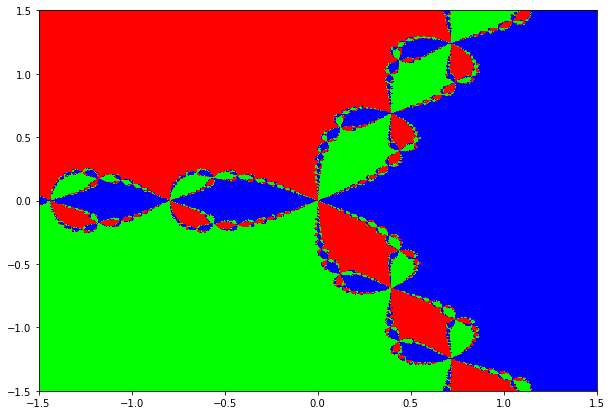

In [111]:
basis_newton(f, Df, zeros, bounds, 500, 100)

In [112]:
f = lambda x: x**3 - x
Df = lambda x: 3*x**2 - 1
zeros = np.array([0, 1, -1])
bounds = np.array([-1.5, 1.5, -1.5, 1.5])

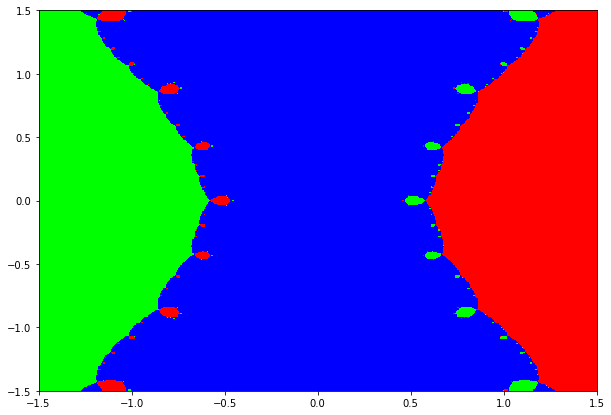

In [113]:
basis_newton(f, Df, zeros, bounds, 500, 100)

# Iterative Solvers

## Problems 1 and 2

In [114]:
def jacobi(A, b, tol=1e-5, maxiters=5000, plot=False):
    
    # Decompose A as A = D + L + U
    D = np.diagonal(A)
    Dinv = np.diag(1 / np.diag(A))
    # Initial guess is the zero vector
    xk = np.zeros(len(b))
    errors = []
    err = tol + 1
    it = 1
    
    while err > tol and it < maxiters:
        
        xkp1 = xk + Dinv @ b - Dinv @ (A @ xk)
        abserr = np.linalg.norm(A@xkp1 - b, np.inf)
        errors.append(abserr)
        err = np.linalg.norm(xkp1 - xk, np.inf)
        it += 1
        xk = xkp1
    
    if plot:
        fig = plt.figure(figsize=(10,7))
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Jacobi Method')
        plt.semilogy(np.arange(1, it, 1), errors)
    return xk

In [115]:
def diag_dom(n, num_entries=None):
    """
    Generate a strictly diagonally dominant (n, n) matrix.
    
    Parameters:
        n (int): The dimension of the system.
        num_entries (int): The number of nonzero values.
            Defaults to n^(3/2)-n.
            
    Returns:
        A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
        
    """

    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

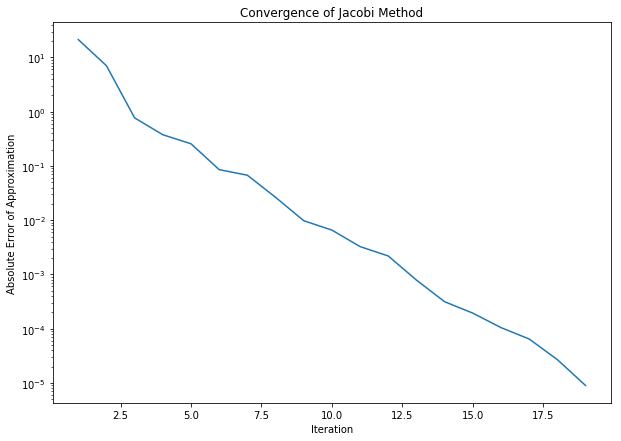

In [116]:
A = diag_dom(10)
b = np.random.random((10,1))
x_j = jacobi(A, b, plot=True)
x_s = la.solve(A, b)

In [117]:
np.allclose(A @ x_j, b)

True

In [118]:
np.allclose(A @ x_s, b)

True

## Problem 3

In [119]:
def gauss_seidal(A, b, tol=1e-5, maxiters=5000, plot=False):
    
    errors = []
    
    err = tol + 1
    it = 1
    n = len(b)
    # Initial guess is the zero vector
    xk = np.zeros(n)
    
    while err > tol and it < maxiters:
        xkp1 = np.copy(xk)
        for ii in range(n):
            xkp1[ii] = xk[ii] + (1 / A[ii,ii]) * (b[ii] - A[ii, :].T @ xk)
        abserr = np.linalg.norm(A@xkp1 - b, np.inf)
        errors.append(abserr)
        err = np.linalg.norm(xkp1 - xk, np.inf)
        it += 1
        xk = xkp1
    
    if plot:
        fig = plt.figure(figsize=(10,7))
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss Seidal')
        plt.semilogy(np.arange(1, it, 1), errors)
    
    return xk

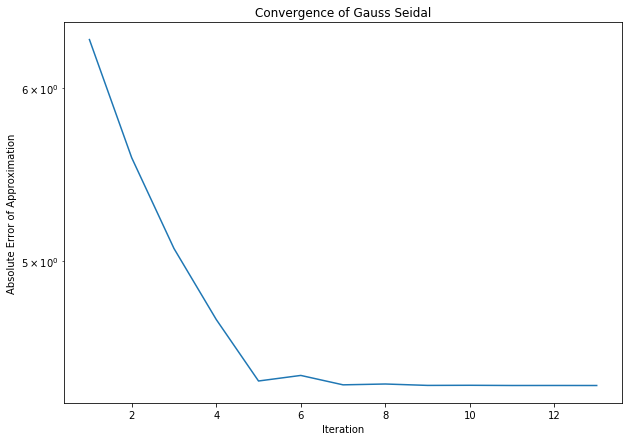

In [120]:
A = diag_dom(10)
b = np.random.random((10,1))
x_j = gauss_seidal(A, b, plot=True)
x_s = la.solve(A, b)

## Problem 4

In [121]:
def gauss_seidal_sparse(A, b, tol=1e-5, maxiters=5000, plot=False):
    
    errors = []
    
    err = tol + 1
    it = 1
    n = len(b)
    # Initial guess is the zero vector
    xk = np.zeros(n)
    A = A.tocsr()
    
    while err > tol and it < maxiters:
        xkp1 = np.copy(xk)
        for ii in range(n):
            # Get the indices of where the i-th row of A starts and ends if the
            # nonzero entries of A were flattened.
            rowstart = A.indptr[ii]
            rowend = A.indptr[ii+1]
            # Multiply only the nonzero elements of the i-th row of A with the
            # corresponding elements of x.
            Aix = A.data[rowstart:rowend] @ xk[A.indices[rowstart:rowend]]
            
            xkp1[ii] = xk[ii] + (1 / A[ii,ii]) * (b[ii] - 1 * Aix)
        
        abserr = np.linalg.norm(A@xkp1 - b, np.inf)
        errors.append(abserr)
        err = np.linalg.norm(xkp1 - xk, np.inf)
        it += 1
        xk = xkp1
    
    if plot:
        fig = plt.figure(figsize=(10,7))
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss Seidal')
        plt.semilogy(np.arange(1, it, 1), errors)
    
    return xk

In [122]:
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)

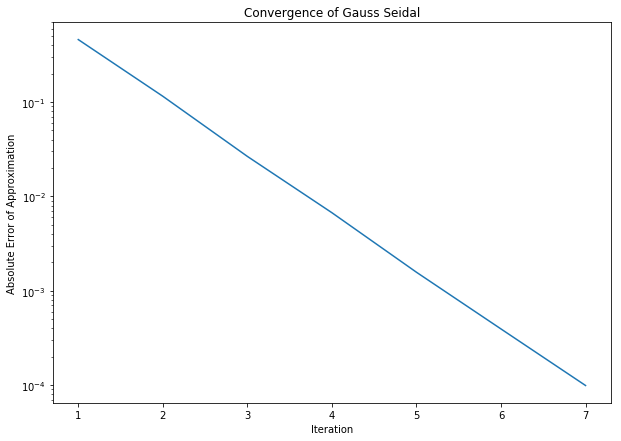

In [123]:
x_j = gauss_seidal_sparse(A, b, plot=True)

## Problem 5

In [124]:
def gauss_seidal_relax_sparse(A, b, w, tol=1e-5, maxiters=5000, plot=False):
    
    errors = []
    
    err = tol + 1
    it = 1
    n = len(b)
    # Initial guess is the zero vector
    xk = np.zeros(n)
    A = A.tocsr()
    
    while err > tol and it < maxiters:
        xkp1 = np.copy(xk)
        for ii in range(n):
            # Get the indices of where the i-th row of A starts and ends if the
            # nonzero entries of A were flattened.
            rowstart = A.indptr[ii]
            rowend = A.indptr[ii+1]
            # Multiply only the nonzero elements of the i-th row of A with the
            # corresponding elements of x.
            Aix = A.data[rowstart:rowend] @ xk[A.indices[rowstart:rowend]]
            
            xkp1[ii] = xk[ii] + (w / A[ii,ii]) * (b[ii] - 1 * Aix)
        
        abserr = np.linalg.norm(A@xkp1 - b, np.inf)
        errors.append(abserr)
        err = np.linalg.norm(xkp1 - xk, np.inf)
        it += 1
        xk = xkp1
    
    if plot:
        fig = plt.figure(figsize=(10,7))
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss Seidal')
        plt.semilogy(np.arange(1, it, 1), errors)
    
    return xk, it

In [125]:
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)
weights = np.linspace(.1, 1, 10)
its = np.zeros(len(weights))
for index, w in enumerate(weights):
    x_j, it = gauss_seidal_relax_sparse(A, b, w, plot=False)
    its[index] = it

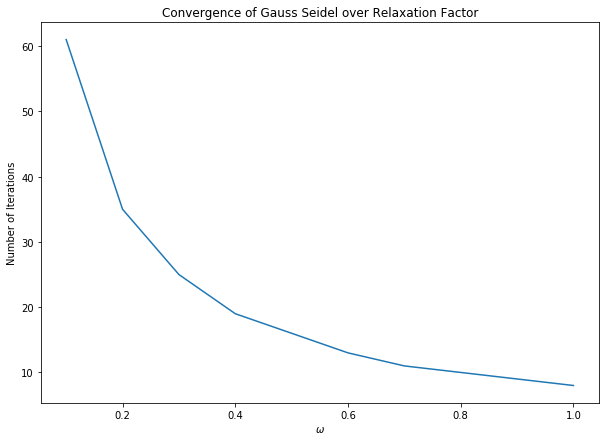

In [126]:
fig = plt.figure(figsize=(10,7))
plt.plot(weights, its)
plt.xlabel(r'$\omega$')
plt.ylabel('Number of Iterations')
plt.title('Convergence of Gauss Seidel over Relaxation Factor')
plt.show()

## Problem 6

In [127]:
def solve_heat(n, w, tol=1e-8, maxiters=100, plot=False):
    
    # Construct B
    offsets = [-1,0,1]
    B = sparse.diags([1,-4,1], offsets, shape=(n,n))

    # Construct Identity Matrix
    I = sparse.diags([1], shape=(n,n))
    
    # Construct A
    rows = []
    for ii in range(n):
        row = []
        for jj in range(n):
            if jj < ii - 1:
                row.append(None)
            elif jj == ii - 1:
                row.append(I)
            elif jj == ii:
                row.append(B)
            elif jj == ii + 1:
                row.append(I)
            else:
                row.append(None)
        rows.append(row)
    
    A = sparse.bmat(rows, format='bsr')

    # Construct b
    lilb = np.zeros(n)
    lilb[0] = -100
    lilb[-1] = -100
    b = np.tile(lilb, n)
    
    u, it = gauss_seidal_relax_sparse(A, b, w, tol, maxiters, plot=False)
    
    if plot:
        x_domain = np.linspace(0, 1, n + 1)
        y_domain = np.linspace(0, 1, n + 1)
        X, Y = np.meshgrid(x_domain, y_domain)
        u_square = u.reshape((n,n))
        fig = plt.figure(figsize=(10,7))
        plt.pcolormesh(X, Y, u_square, cmap='coolwarm')
        plt.colorbar()
        plt.show()
    return u, it
    

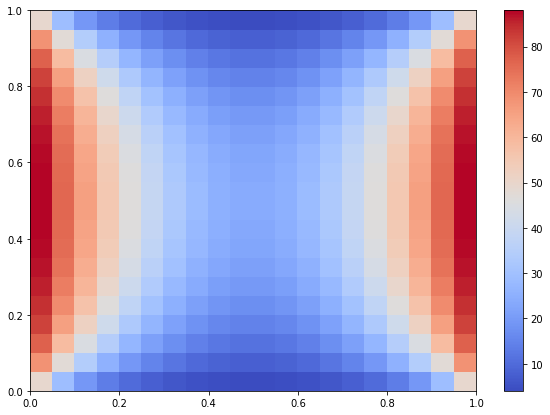

In [128]:
u, it = solve_heat(20, 1, plot=True)

## Problem 7

In [129]:
n = 4
weights = np.linspace(1, 1.95, 10)
its = np.zeros(len(weights))
for index, w in enumerate(weights):
    x_j, it = solve_heat(n, w, 1e-2, 1000, plot=False)
    its[index] = it

/Users/rebekahdix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [130]:
argmin = np.argmin(its)
weights[argmin]

1.3166666666666667

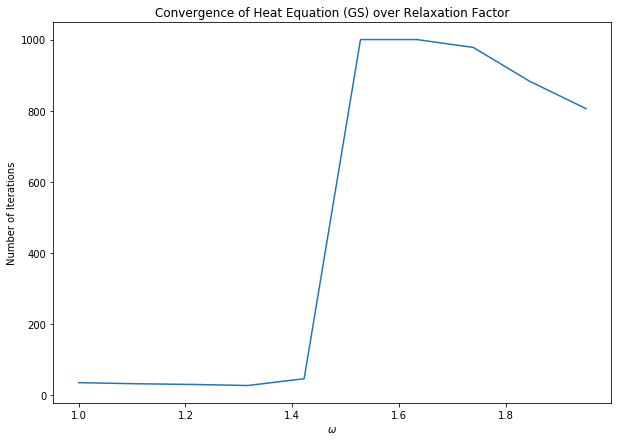

In [131]:
fig = plt.figure(figsize=(10,7))
plt.plot(weights, its)
plt.xlabel(r'$\omega$')
plt.ylabel('Number of Iterations')
plt.title('Convergence of Heat Equation (GS) over Relaxation Factor')
plt.show()